In [81]:
import pandas as pd
import folium
import ast
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression


import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

# Load the data

In [82]:
df_pop = pd.read_excel('./data/ACS5yrNTA/demo_2016acs5yr_nta.xlsx')
print(df_pop.shape)

df_econ = pd.read_excel('./data/ACS5yrNTA/econ_2016acs5yr_nta.xlsx')
print(df_econ.shape)

df_house = pd.read_excel('./data/ACS5yrNTA/hous_2016acs5yr_nta.xlsx')
print(df_house.shape)

df_soc = pd.read_excel('./data/ACS5yrNTA/soc_2016acs5yr_nta.xlsx')
print(df_soc.shape)

(195, 484)
(195, 659)
(195, 524)


/Users/TinyJiew/opt/anaconda3/envs/pantalone/lib/python3.10/site-packages/openpyxl/reader/workbook.py:118: UserWarning: Print area cannot be set to Defined name: #N/A.
  warn(f"Print area cannot be set to Defined name: {defn.value}.")


(195, 2714)


In [83]:
df_bus = pd.read_csv('./data/Legally_Operating_Businesses_20240905.csv')
print(df_bus.shape)

/var/folders/mg/sts1jc3x4vg3ykt3408_lxs00000gn/T/ipykernel_11003/1500472773.py:1: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_bus = pd.read_csv('./data/Legally_Operating_Businesses_20240905.csv')


(281413, 27)


In [84]:
# check if there is any trader joe
df_bus[df_bus['Business Name'].str.lower().str.contains('trader') & df_bus['Business Name'].str.lower().str.contains('joe')]

,DCA License Number,License Type,License Expiration Date,License Status,License Creation Date,Industry,Business Name,Business Name 2,Address Building,Address Street Name,...,Community Board,Council District,BIN,BBL,NTA,Census Tract,Detail,Longitude,Latitude,Location


In [85]:
# we want to focus on NYC only
print(df_bus['Address Borough'].value_counts())

# filter the dataset to only keep 5 boroughs, remove rows with mispelled
NYC_BOROUGHS = ['Queens', 'Brooklyn', 'Manhattan', 'Bronx', 'Staten Island']
df_bus = df_bus[df_bus['Address Borough'].isin(NYC_BOROUGHS)]
print(df_bus.shape)

Address Borough
Brooklyn         50346
Queens           45800
Manhattan        40435
Bronx            24695
Outside NYC      14775
Staten Island     9265
MANHATTAN           46
QUEENS              17
BROOKLYN            15
BRONX                9
Name: count, dtype: int64
(170541, 27)


In [86]:
# we want to focus on recommending the specific NTA (Neighborhood Tabulation Area) where the business is located.
# remove row with missing NTA
df_bus = df_bus.dropna(subset=['NTA'])
print(df_bus.shape)

df_bus[['Address Borough', 'NTA']].value_counts()

(137476, 27)


Address Borough  NTA 
Manhattan        MN17    4222
                 MN13    2288
                 MN24    1936
Queens           QN70    1905
                 QN61    1904
                         ... 
Brooklyn         MN24       1
Manhattan        BK78       1
                 BK91       1
Brooklyn         MN19       1
Queens           MN36       1
Name: count, Length: 209, dtype: int64

In [87]:
# check how many industries
df_bus['Industry'].value_counts()

Industry
Tobacco Retail Dealer             37491
Home Improvement Contractor       21261
Secondhand Dealer - General       12621
Electronics Store                 11933
Stoop Line Stand                   7376
Laundry                            6832
Electronic & Appliance Service     5325
Laundries                          4353
Laundry Jobber                     4339
Sidewalk Cafe                      3728
Garage                             3106
Electronic Cigarette Dealer        2923
Secondhand Dealer - Auto           2322
Parking Lot                        1720
Dealer In Products                 1600
Tow Truck Company                  1232
Employment Agency                  1102
Special Sale                       1005
Amusement Device Temporary          979
Amusement Device Portable           942
Pawnbroker                          766
Cabaret                             602
Debt Collection Agency              496
Pedicab Business                    422
Amusement Device Permanent     

In [95]:
# assume that the trader joe's lies in between  Stoop Line Stand  and General Vendor industries
# note that general vendor was filtered as they are outside the NYC
# let's use the sum of businesses of two industries as indicator of supermarket success

df_sup_success = df_bus[df_bus['Industry'].isin(['Stoop Line Stand', 'General Vendor'])]
df_sup_success = df_sup_success[['Address Borough', 'NTA', 'Business Name', 'Industry']]
df_sup_success = df_sup_success.groupby(['Address Borough', 'NTA', 'Industry'])['Business Name'].count().reset_index()
df_sup_success = df_sup_success.rename(columns={'Business Name':'Shop_Count', 'NTA':'GeoID'})
df_sup_success.head(5)

,Address Borough,GeoID,Industry,Shop_Count
0,Bronx,BX01,Stoop Line Stand,13
1,Bronx,BX03,Stoop Line Stand,6
2,Bronx,BX05,Stoop Line Stand,54
3,Bronx,BX06,Stoop Line Stand,30
4,Bronx,BX07,Stoop Line Stand,10


# Feature Engineering

There are too many variables so it would be best to filter them out and using the shop_count as indicator

In [96]:
# using correlation features
# merge df_pop

df_pop_fea = pd.merge(df_pop, df_sup_success, on='GeoID')
df_pop_fea.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181 entries, 0 to 180
Columns: 487 entries, GeoType to Shop_Count
dtypes: float64(385), int64(96), object(6)
memory usage: 688.8+ KB


In [97]:
# remove object columns
df_pop_fea = df_pop_fea.drop(columns=['GeoType','GeogName', 'GeoID', 'Borough', 'Address Borough', 'Industry'])
df_pop_fea.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181 entries, 0 to 180
Columns: 481 entries, Pop_1E to Shop_Count
dtypes: float64(385), int64(96)
memory usage: 680.3 KB


In [98]:
# remove columns that contain all missing rows
df_pop_fea = df_pop_fea.drop(columns=df_pop_fea.columns[df_pop_fea.isnull().all()].to_list())

In [99]:
# replace missing value with mean
for col in df_pop_fea.columns:
    col_mean = df_pop_fea[col].mean()
    df_pop_fea[col].fillna(col_mean, inplace=True)

print(df_pop_fea.columns[df_pop_fea.isnull().any()])

Index([], dtype='object')


/var/folders/mg/sts1jc3x4vg3ykt3408_lxs00000gn/T/ipykernel_11003/1246015328.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_pop_fea[col].fillna(col_mean, inplace=True)


In [100]:
df_pop_fea

,Pop_1E,Pop_1M,Pop_1C,Pop_1P,MaleE,MaleM,MaleC,MaleP,MaleZ,FemE,...,AsnOAsnM,AsnOAsnC,AsnOAsnP,AsnOAsnZ,Asn2plE,Asn2plM,Asn2plC,Asn2plP,Asn2plZ,Shop_Count
0,33163,1246.0,2.3,100.0,16686,781.0,2.8,50.3,1.4,16477,...,42.000000,54.900000,0.400000,0.300000,152,103.000000,41.400000,1.300000,0.800000,34
1,79134,1724.0,1.3,100.0,37829,1075.0,1.7,47.8,0.9,41305,...,113.000000,60.900000,1.000000,1.000000,93,61.000000,40.200000,0.800000,0.500000,152
2,75318,1993.0,1.6,100.0,36491,1276.0,2.1,48.4,1.1,38827,...,29.000000,67.800000,1.100000,1.200000,56,52.000000,56.700000,2.400000,2.200000,25
3,64267,1675.0,1.6,100.0,31283,1083.0,2.1,48.7,1.1,32984,...,57.000000,73.200000,0.200000,0.200000,232,175.000000,45.900000,0.900000,0.700000,105
4,91646,1975.0,1.3,100.0,44651,1241.0,1.7,48.7,0.9,46995,...,190.000000,41.500000,0.700000,0.500000,428,202.000000,28.700000,1.100000,0.500000,173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,37395,1423.0,2.3,100.0,17966,926.0,3.1,48.0,1.7,19429,...,54.000000,84.700000,5.600000,7.500000,0,89.626866,59.963433,1.870896,1.837313,32
177,35752,1461.0,2.5,100.0,17105,998.0,3.5,47.8,2.0,18647,...,73.623077,77.086154,1.812308,2.182308,0,89.626866,59.963433,1.870896,1.837313,40
178,28437,1232.0,2.6,100.0,13282,749.0,3.4,46.7,1.7,15155,...,50.000000,78.100000,1.100000,1.400000,67,97.000000,88.400000,1.900000,2.700000,30
179,65043,1793.0,1.7,100.0,30020,1109.0,2.2,46.2,1.1,35023,...,13.000000,74.100000,1.400000,1.600000,0,89.626866,59.963433,1.870896,1.837313,42


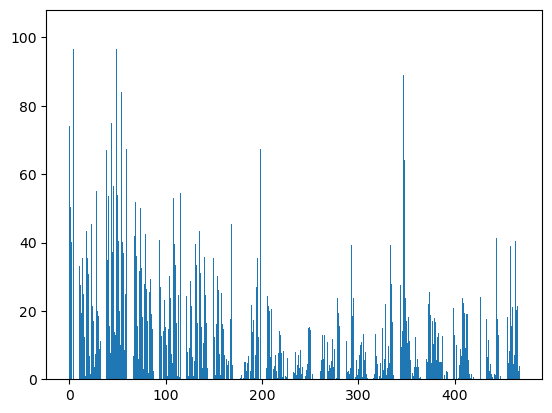

In [101]:
# https://machinelearningmastery.com/feature-selection-for-regression-data/
#  Feature selection instead, takes the target into consideration. 
# It will rank your input variables in terms of how useful they are to predict the target value.
# it is different from PCA that try to reduce dimensionality by exploring how one feature of the data is expressed 
# in terms of the other features(linear dependency)

def select_features(X_train, y_train, k):
 # configure to select all features
 fs = SelectKBest(score_func=f_regression, k=k)
 # learn relationship from training data
 fs.fit(X_train, y_train)
 # transform train input data
 X_train_fs = fs.transform(X_train)
 return X_train_fs, fs

# feature selection
X_train_fs, fs = select_features(df_pop_fea.drop(columns=['Shop_Count']), df_pop_fea['Shop_Count'], 'all')
# # what are scores for the features
# for i in range(len(fs.scores_)):
#  print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [102]:
df_pop = pd.merge(df_pop, df_sup_success, on='GeoID')
df_pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181 entries, 0 to 180
Columns: 487 entries, GeoType to Shop_Count
dtypes: float64(385), int64(96), object(6)
memory usage: 688.8+ KB


In [103]:
df_pop

,GeoType,GeogName,GeoID,Borough,Pop_1E,Pop_1M,Pop_1C,Pop_1P,Pop_1Z,MaleE,...,AsnOAsnP,AsnOAsnZ,Asn2plE,Asn2plM,Asn2plC,Asn2plP,Asn2plZ,Address Borough,Industry,Shop_Count
0,NTA2010,Bath Beach,BK27,Brooklyn,33163,1246.0,2.3,100.0,NaN,16686,...,0.4,0.3,152,103.0,41.4,1.3,0.8,Brooklyn,Stoop Line Stand,34
1,NTA2010,Bay Ridge,BK31,Brooklyn,79134,1724.0,1.3,100.0,NaN,37829,...,1.0,1.0,93,61.0,40.2,0.8,0.5,Brooklyn,Stoop Line Stand,152
2,NTA2010,Bedford,BK75,Brooklyn,75318,1993.0,1.6,100.0,NaN,36491,...,1.1,1.2,56,52.0,56.7,2.4,2.2,Brooklyn,Stoop Line Stand,25
3,NTA2010,Bensonhurst East,BK29,Brooklyn,64267,1675.0,1.6,100.0,NaN,31283,...,0.2,0.2,232,175.0,45.9,0.9,0.7,Brooklyn,Stoop Line Stand,105
4,NTA2010,Bensonhurst West,BK28,Brooklyn,91646,1975.0,1.3,100.0,NaN,44651,...,0.7,0.5,428,202.0,28.7,1.1,0.5,Brooklyn,Stoop Line Stand,173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,NTA2010,West Concourse,BX63,The Bronx,37395,1423.0,2.3,100.0,NaN,17966,...,5.6,7.5,0,NaN,NaN,NaN,NaN,Bronx,Stoop Line Stand,32
177,NTA2010,West Farms-Bronx River,BX08,The Bronx,35752,1461.0,2.5,100.0,NaN,17105,...,NaN,NaN,0,NaN,NaN,NaN,NaN,Bronx,Stoop Line Stand,40
178,NTA2010,Westchester-Unionport,BX59,The Bronx,28437,1232.0,2.6,100.0,NaN,13282,...,1.1,1.4,67,97.0,88.4,1.9,2.7,Bronx,Stoop Line Stand,30
179,NTA2010,Williamsbridge-Olinville,BX44,The Bronx,65043,1793.0,1.7,100.0,NaN,30020,...,1.4,1.6,0,NaN,NaN,NaN,NaN,Bronx,Stoop Line Stand,42


In [104]:
# can we do the same for all NTA-level data
df_nta = df_pop.copy()
df_nta = pd.merge(df_nta, df_econ, on='GeoID')
df_nta = df_nta.drop(columns=['GeoType_x', 'GeoType_y', 'GeogName_x', 'GeogName_y', 'Borough_x', 'Borough_y'])
df_nta = pd.merge(df_nta, df_house, on='GeoID')
df_nta = pd.merge(df_nta, df_soc, on='GeoID')
df_nta = df_nta.drop(columns=['GeoType_x', 'GeoType_y', 'GeogName_x', 'GeogName_y', 'Borough_x', 'Borough_y'])
df_nta.shape

(181, 4369)

In [108]:
df_nta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Columns: 4385 entries, GeoID to Pop_Pct_With_Degree
dtypes: float64(3523), int64(857), object(5)
memory usage: 6.3+ MB


In [109]:
df_nta = pd.merge(df_nta, df_sup_success, on='GeoID')

In [112]:
df_nta

,GeoID,Pop_1E,Pop_1M,Pop_1C,Pop_1P,Pop_1Z,MaleE,MaleM,MaleC,MaleP,...,Mean_Household_Income,Pop_Pct_Healthy,Pop_Pct_With_Car,House_Median,Rent_Median,Pop_Pct_with_Family,Pop_Pct_With_Degree,Address Borough,Industry,Shop_Count
0,BK27,33163,1246.0,2.3,100.0,NaN,16686,781.0,2.8,50.3,...,75950.0,0.851433,0.609205,685011.0,1299.0,0.718148,0.336202,Brooklyn,Stoop Line Stand,34
1,BK31,79134,1724.0,1.3,100.0,NaN,37829,1075.0,1.7,47.8,...,86319.0,0.889538,0.548691,687001.0,1385.0,0.565443,0.464265,Brooklyn,Stoop Line Stand,152
2,BK75,75318,1993.0,1.6,100.0,NaN,36491,1276.0,2.1,48.4,...,62616.0,0.871836,0.312752,722811.0,1165.0,0.557965,0.321807,Brooklyn,Stoop Line Stand,25
3,BK29,64267,1675.0,1.6,100.0,NaN,31283,1083.0,2.1,48.7,...,65715.0,0.829711,0.540046,657026.0,1209.0,0.733583,0.301847,Brooklyn,Stoop Line Stand,105
4,BK28,91646,1975.0,1.3,100.0,NaN,44651,1241.0,1.7,48.7,...,70198.0,0.825890,0.526765,708946.0,1259.0,0.729948,0.262382,Brooklyn,Stoop Line Stand,173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,BX63,37395,1423.0,2.3,100.0,NaN,17966,926.0,3.1,48.0,...,37550.0,0.742167,0.228866,213234.0,1098.0,0.650325,0.139636,Bronx,Stoop Line Stand,32
195,BX08,35752,1461.0,2.5,100.0,NaN,17105,998.0,3.5,47.8,...,39917.0,0.730384,0.394016,453009.0,1108.0,0.683944,0.092649,Bronx,Stoop Line Stand,40
196,BX59,28437,1232.0,2.6,100.0,NaN,13282,749.0,3.4,46.7,...,57590.0,0.832139,0.522319,425647.0,1308.0,0.696242,0.185358,Bronx,Stoop Line Stand,30
197,BX44,65043,1793.0,1.7,100.0,NaN,30020,1109.0,2.2,46.2,...,53405.0,0.857238,0.512452,378872.0,1204.0,0.680864,0.187137,Bronx,Stoop Line Stand,42


In [113]:
df_nta['Pop_Total_25_44'] = df_nta.apply(lambda x: x['Pop25t29E'] + x['Pop30t34E'] + x['Pop35t39E'] + x['Pop40t44E'], axis=1)
df_nta['Pop_Pct_25_44'] = df_nta.apply(lambda x: x['Pop_Total_25_44'] / x['Pop_1E'] , axis=1)

df_nta['Pop_Pct_Hisp_Latin'] = df_nta.apply(lambda x: x['Hsp1E'] / x['Pop_2E'], axis=1)
df_nta['Pop_Pct_Non_Hisp_Latin'] = df_nta.apply(lambda x: x['NHspE'] / x['Pop_2E'], axis=1)

df_nta['Pop_Pct_Employ'] = df_nta.apply(lambda x: x['CvEm16pl1E'] / x['Pop16plE'], axis=1) 

#earning $75,000 to $99,999
df_nta['Pop_Pct_Earn_75_99'] = df_nta.apply(lambda x: x['HHI75t99E'] / x['HH2E'], axis=1)
df_nta['Mean_Household_Income'] = df_nta['MnHHIncE']

#healthy with insurance coverage of overall employment
df_nta['Pop_Pct_Healthy'] = df_nta.apply(lambda x: x['EmHInsE'] / x['CvLFEmE'], axis=1) 

# with car
df_nta['Pop_Pct_With_Car'] = df_nta.apply(lambda x: (x['Vhcl1AvE'] + x['Vhcl2AvE'] + x['Vhcl3plAvE']) / x['OcHU4E'], axis=1)
df_nta['House_Median'] = df_nta['MdVlE'] #house price
df_nta['Rent_Median'] = df_nta['MdGRE']

# have family
df_nta['Pop_Pct_with_Family'] = df_nta.apply(lambda x: x['Fam1E'] / x['HH1E'], axis=1) 

#education #Bachelor's degree or higher
df_nta['Pop_Pct_With_Degree'] = df_nta.apply(lambda x: x['EA_BchDHE'] / x['EA_P25plE'], axis=1) 

df_nta['People_Per_Shop'] = df_nta.apply(lambda x: (x['Pop_Total_25_44'] / x['Shop_Count']) if x['Shop_Count'] > 0 else x['Pop_Total_25_44'], axis=1)

analyse_columns = ['Pop_Total_25_44', 'Pop_Pct_25_44', 'Pop_Pct_Hisp_Latin', 'Pop_Pct_Non_Hisp_Latin', 'Pop_Pct_Employ', 'Pop_Pct_Earn_75_99', 
                   'Mean_Household_Income', 'Pop_Pct_Healthy', 'Pop_Pct_With_Car', 'House_Median', 'Rent_Median', 
                   'Pop_Pct_with_Family', 'Pop_Pct_With_Degree', 'Shop_Count', 'People_Per_Shop', 'GeoID']

df_nta = df_nta[analyse_columns]

In [114]:
# remove columns that contain all missing rows
df_nta = df_nta.drop(columns=df_nta.columns[df_nta.isnull().all()].to_list())

# replace missing value with mean
for col in df_nta.columns:
    if col not in ['GeoID', 'Address Borough', 'Industry']:
        col_mean = df_nta[col].mean()
        df_nta[col].fillna(col_mean, inplace=True)

print(df_nta.columns[df_nta.isnull().any()])

Index([], dtype='object')


/var/folders/mg/sts1jc3x4vg3ykt3408_lxs00000gn/T/ipykernel_11003/687371754.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_nta[col].fillna(col_mean, inplace=True)


Feature Pop_Total_25_44: 12.057119
Feature Pop_Pct_25_44: 3.534882
Feature Pop_Pct_Hisp_Latin: 6.791932
Feature Pop_Pct_Non_Hisp_Latin: 6.791932
Feature Pop_Pct_Employ: 11.396775
Feature Pop_Pct_Earn_75_99: 3.424972
Feature Mean_Household_Income: 6.677157
Feature Pop_Pct_Healthy: 8.758359
Feature Pop_Pct_With_Car: 0.459772
Feature House_Median: 0.181578
Feature Rent_Median: 7.996473
Feature Pop_Pct_with_Family: 4.467019
Feature Pop_Pct_With_Degree: 10.322476
Feature Shop_Count: 13.736515


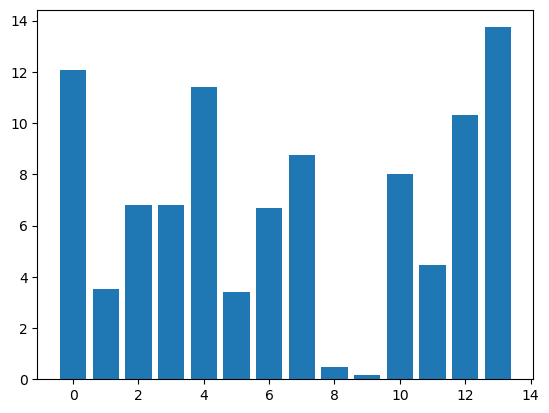

In [115]:
# feature selection
X_train_fs, fs = select_features(df_nta.drop(columns=['People_Per_Shop', 'GeoID']), df_nta['People_Per_Shop'], 10)
cols = df_nta.drop(columns=['People_Per_Shop', 'GeoID']).columns
# # what are scores for the features
for i in range(len(fs.scores_)):
 print('Feature %s: %f' % (cols[i], fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [116]:
for idx, col in enumerate(cols):
    print(col, fs.get_support()[idx])

Pop_Total_25_44 True
Pop_Pct_25_44 False
Pop_Pct_Hisp_Latin True
Pop_Pct_Non_Hisp_Latin True
Pop_Pct_Employ True
Pop_Pct_Earn_75_99 False
Mean_Household_Income True
Pop_Pct_Healthy True
Pop_Pct_With_Car False
House_Median False
Rent_Median True
Pop_Pct_with_Family True
Pop_Pct_With_Degree True
Shop_Count True


# Clustering

In [117]:

X_train_fs

array([[1.05220000e+04, 1.76733106e-01, 8.23266894e-01, ...,
        7.18148407e-01, 3.36201830e-01, 3.40000000e+01],
       [2.46150000e+04, 1.78608436e-01, 8.21391564e-01, ...,
        5.65443306e-01, 4.64264842e-01, 1.52000000e+02],
       [2.55840000e+04, 1.94933482e-01, 8.05066518e-01, ...,
        5.57964619e-01, 3.21806728e-01, 2.50000000e+01],
       ...,
       [7.93300000e+03, 6.36248549e-01, 3.63751451e-01, ...,
        6.96241596e-01, 1.85357573e-01, 3.00000000e+01],
       [1.71930000e+04, 2.52156266e-01, 7.47843734e-01, ...,
        6.80863939e-01, 1.87137331e-01, 4.20000000e+01],
       [1.24670000e+04, 1.74450799e-01, 8.25549201e-01, ...,
        6.97100182e-01, 2.74353033e-01, 1.00000000e+01]])

Text(0.5, 1.0, 'Elbow Method For Optimal k')

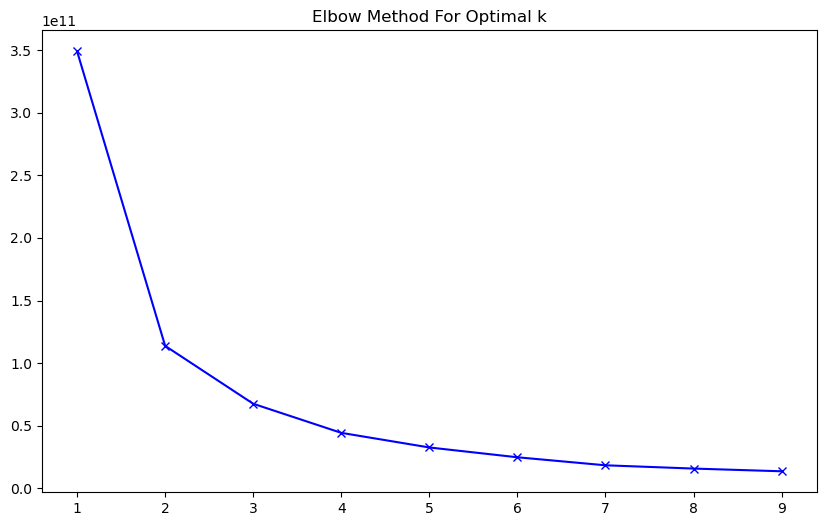

In [118]:
# perform clustering based on the feature selections
sum_of_squared_distances = []

# maximum of 10 clusters
K = range(1,10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=1, n_init=20).fit(X_train_fs)
    sum_of_squared_distances.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.title('Elbow Method For Optimal k')

In [119]:
# k = 4 is optimal number
# let's breakdown the NTA into 3 groups

# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=100).fit(X_train_fs)

In [120]:
nyc_label = df_nta.copy()
nyc_label['label'] = kmeans.labels_
nyc_label

,Pop_Total_25_44,Pop_Pct_25_44,Pop_Pct_Hisp_Latin,Pop_Pct_Non_Hisp_Latin,Pop_Pct_Employ,Pop_Pct_Earn_75_99,Mean_Household_Income,Pop_Pct_Healthy,Pop_Pct_With_Car,House_Median,Rent_Median,Pop_Pct_with_Family,Pop_Pct_With_Degree,Shop_Count,People_Per_Shop,GeoID,label
0,10522,0.317281,0.176733,0.823267,0.553230,0.118306,75950.0,0.851433,0.609205,685011.0,1299.0,0.718148,0.336202,34,309.470588,BK27,0
1,24615,0.311055,0.178608,0.821392,0.594175,0.122674,86319.0,0.889538,0.548691,687001.0,1385.0,0.565443,0.464265,152,161.940789,BK31,0
2,25584,0.339680,0.194933,0.805067,0.589010,0.087072,62616.0,0.871836,0.312752,722811.0,1165.0,0.557965,0.321807,25,1023.360000,BK75,0
3,18681,0.290678,0.123283,0.876717,0.553531,0.115293,65715.0,0.829711,0.540046,657026.0,1209.0,0.733583,0.301847,105,177.914286,BK29,0
4,28128,0.306920,0.145975,0.854025,0.561085,0.114614,70198.0,0.825890,0.526765,708946.0,1259.0,0.729948,0.262382,173,162.589595,BK28,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,11003,0.294237,0.707046,0.292954,0.533988,0.064834,37550.0,0.742167,0.228866,213234.0,1098.0,0.650325,0.139636,32,343.843750,BX63,3
195,10220,0.285858,0.646090,0.353910,0.507790,0.078550,39917.0,0.730384,0.394016,453009.0,1108.0,0.683944,0.092649,40,255.500000,BX08,3
196,7933,0.278968,0.636249,0.363751,0.522259,0.129174,57590.0,0.832139,0.522319,425647.0,1308.0,0.696242,0.185358,30,264.433333,BX59,3
197,17193,0.264333,0.252156,0.747844,0.533886,0.090118,53405.0,0.857238,0.512452,378872.0,1204.0,0.680864,0.187137,42,409.357143,BX44,3


# Analyse clustering result

In [121]:
# merge back 
nyc_label = pd.merge(nyc_label, df_pop[['GeogName', 'GeoID', 'Borough']], on = 'GeoID')
nyc_label

,Pop_Total_25_44,Pop_Pct_25_44,Pop_Pct_Hisp_Latin,Pop_Pct_Non_Hisp_Latin,Pop_Pct_Employ,Pop_Pct_Earn_75_99,Mean_Household_Income,Pop_Pct_Healthy,Pop_Pct_With_Car,House_Median,Rent_Median,Pop_Pct_with_Family,Pop_Pct_With_Degree,Shop_Count,People_Per_Shop,GeoID,label,GeogName,Borough
0,10522,0.317281,0.176733,0.823267,0.553230,0.118306,75950.0,0.851433,0.609205,685011.0,1299.0,0.718148,0.336202,34,309.470588,BK27,0,Bath Beach,Brooklyn
1,24615,0.311055,0.178608,0.821392,0.594175,0.122674,86319.0,0.889538,0.548691,687001.0,1385.0,0.565443,0.464265,152,161.940789,BK31,0,Bay Ridge,Brooklyn
2,25584,0.339680,0.194933,0.805067,0.589010,0.087072,62616.0,0.871836,0.312752,722811.0,1165.0,0.557965,0.321807,25,1023.360000,BK75,0,Bedford,Brooklyn
3,18681,0.290678,0.123283,0.876717,0.553531,0.115293,65715.0,0.829711,0.540046,657026.0,1209.0,0.733583,0.301847,105,177.914286,BK29,0,Bensonhurst East,Brooklyn
4,28128,0.306920,0.145975,0.854025,0.561085,0.114614,70198.0,0.825890,0.526765,708946.0,1259.0,0.729948,0.262382,173,162.589595,BK28,0,Bensonhurst West,Brooklyn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,11003,0.294237,0.707046,0.292954,0.533988,0.064834,37550.0,0.742167,0.228866,213234.0,1098.0,0.650325,0.139636,32,343.843750,BX63,3,West Concourse,The Bronx
219,10220,0.285858,0.646090,0.353910,0.507790,0.078550,39917.0,0.730384,0.394016,453009.0,1108.0,0.683944,0.092649,40,255.500000,BX08,3,West Farms-Bronx River,The Bronx
220,7933,0.278968,0.636249,0.363751,0.522259,0.129174,57590.0,0.832139,0.522319,425647.0,1308.0,0.696242,0.185358,30,264.433333,BX59,3,Westchester-Unionport,The Bronx
221,17193,0.264333,0.252156,0.747844,0.533886,0.090118,53405.0,0.857238,0.512452,378872.0,1204.0,0.680864,0.187137,42,409.357143,BX44,3,Williamsbridge-Olinville,The Bronx


In [123]:
# create new dataframe to summarise each label
results = []
for label in sorted(nyc_label.label.unique()):
    df = nyc_label[nyc_label.label == label]
    nta_names = df.GeogName.unique()
    nta_ids = df.GeoID.unique()
    label_dict = {
        'label': label,
        'NTA_Name': df.GeogName.unique(),
        'NTA_ID': df.GeoID.unique(),
        'Avg_Pop_Pct_25_44': df.Pop_Pct_25_44.mean(),
        'Avg_Pop_Pct_Hisp_Latin': df.Pop_Pct_Hisp_Latin.mean(), 
        'Avg_Pop_Pct_Non_Hisp_Latin': df.Pop_Pct_Non_Hisp_Latin.mean(), 
        'Avg_Pop_Pct_Employ': df.Pop_Pct_Employ.mean(), 
        'Avg_Pop_Pct_Earn_75_99': df.Pop_Pct_Earn_75_99.mean(), 
        'Avg_Pop_Pct_Healthy': df.Pop_Pct_Healthy.mean(),
        'Avg_Pop_Pct_With_Car': df.Pop_Pct_With_Car.mean(), 
        'Avg_House_Median': df.House_Median.mean(), 
        'Avg_Rent_Median': df.Rent_Median.mean(), 
        'Avg_Pop_Pct_with_Family': df.Pop_Pct_with_Family.mean(), 
        'Avg_Pop_Pct_With_Degree': df.Pop_Pct_With_Degree.mean(), 
        'Avg_Shop_Count': df.Shop_Count.mean()
    }
    results.append(label_dict)
    print(f"Group {label}")

Group 0
Group 1
Group 2
Group 3


In [124]:
df_results = pd.DataFrame(results)
df_results.head()

,label,NTA_Name,NTA_ID,Avg_Pop_Pct_25_44,Avg_Pop_Pct_Hisp_Latin,Avg_Pop_Pct_Non_Hisp_Latin,Avg_Pop_Pct_Employ,Avg_Pop_Pct_Earn_75_99,Avg_Pop_Pct_Healthy,Avg_Pop_Pct_With_Car,Avg_House_Median,Avg_Rent_Median,Avg_Pop_Pct_with_Family,Avg_Pop_Pct_With_Degree,Avg_Shop_Count
0,0,"[Bath Beach, Bay Ridge, Bedford, Bensonhurst E...","[BK27, BK31, BK75, BK29, BK28, BK19, BK77, BK5...",0.298986,0.234951,0.765049,0.575154,0.127250,0.841861,0.562314,498698.494253,1282.160920,0.676154,0.288744,42.666667
1,1,"[Brooklyn Heights-Cobble Hill, Park Slope-Gowa...","[BK09, BK37, MN25, MN21, MN13, MN31, MN14, MN1...",0.415927,0.100103,0.899897,0.708230,0.108323,0.953092,0.265528,885779.896552,2159.241379,0.384434,0.790477,40.862069
2,2,"[Carroll Gardens-Columbia Street-Red Hook, Cli...","[BK33, BK69, BK38, BK68, BK45, BK76, BK73, BK4...",0.315732,0.156529,0.843471,0.604086,0.131067,0.911321,0.645082,594109.125000,1534.400000,0.607895,0.465842,19.100000
3,3,"[Borough Park, Brownsville, Bushwick South, Cr...","[BK88, BK81, BK78, BK61, BK83, BK82, BK85, BK9...",0.296407,0.536199,0.463801,0.533764,0.095734,0.807833,0.333378,392865.865672,1083.074627,0.636971,0.209020,40.537313


In [125]:
# for each attribute give me the label that has the highest average
for col in df_results.columns[3:]:
    if col != 'Avg_shop_count':
        max_index = df_results[col].idxmax()
        label = df_results.loc[max_index]['label']
    else:
        min_index = df_results[col].idxmin()
        label = df_results.loc[min_index]['label']
    print(f"Variable: {col} Label: {label}")

Variable: Avg_Pop_Pct_25_44 Label: 1
Variable: Avg_Pop_Pct_Hisp_Latin Label: 3
Variable: Avg_Pop_Pct_Non_Hisp_Latin Label: 1
Variable: Avg_Pop_Pct_Employ Label: 1
Variable: Avg_Pop_Pct_Earn_75_99 Label: 2
Variable: Avg_Pop_Pct_Healthy Label: 1
Variable: Avg_Pop_Pct_With_Car Label: 2
Variable: Avg_House_Median Label: 1
Variable: Avg_Rent_Median Label: 1
Variable: Avg_Pop_Pct_with_Family Label: 0
Variable: Avg_Pop_Pct_With_Degree Label: 1
Variable: Avg_Shop_Count Label: 0


In [129]:
# From the above analysis, we can see that label 0 is the best
# let's look on label 0
nyc_label_0 = nyc_label[nyc_label.label == 1]
nyc_label_0 = nyc_label_0.reset_index()
nyc_label_0.head(5)

,index,Pop_Total_25_44,Pop_Pct_25_44,Pop_Pct_Hisp_Latin,Pop_Pct_Non_Hisp_Latin,Pop_Pct_Employ,Pop_Pct_Earn_75_99,Mean_Household_Income,Pop_Pct_Healthy,Pop_Pct_With_Car,House_Median,Rent_Median,Pop_Pct_with_Family,Pop_Pct_With_Degree,Shop_Count,People_Per_Shop,GeoID,label,GeogName,Borough
0,7,10075,0.417357,0.080737,0.919263,0.657177,0.108052,178252.0,0.951727,0.302188,768459.0,2084.0,0.438845,0.780695,12,839.583333,BK09,1,Brooklyn Heights-Cobble Hill,Brooklyn
1,52,32605,0.441318,0.166701,0.833299,0.748220,0.119466,160700.0,0.941202,0.428837,997876.0,2050.0,0.541689,0.756533,73,446.643836,BK37,1,Park Slope-Gowanus,Brooklyn
2,64,23312,0.509697,0.086582,0.913418,0.776267,0.095135,192766.0,0.954857,0.214823,807691.0,2931.0,0.402872,0.846186,33,706.424242,MN25,1,Battery Park City-Lower Manhattan,Manhattan
3,72,11983,0.429714,0.074984,0.925016,0.705994,0.123032,172590.0,0.952281,0.196160,726595.0,2282.0,0.275852,0.812327,33,363.121212,MN21,1,Gramercy,Manhattan
4,74,35194,0.455851,0.140380,0.859620,0.733970,0.083254,184732.0,0.949313,0.202711,913941.0,2170.0,0.307331,0.744207,107,328.915888,MN13,1,Hudson Yards-Chelsea-Flat Iron-Union Square,Manhattan


<Axes: title={'center': 'NYC residential neighbourhoods'}, xlabel='People per shop', ylabel='Mean Household Income'>

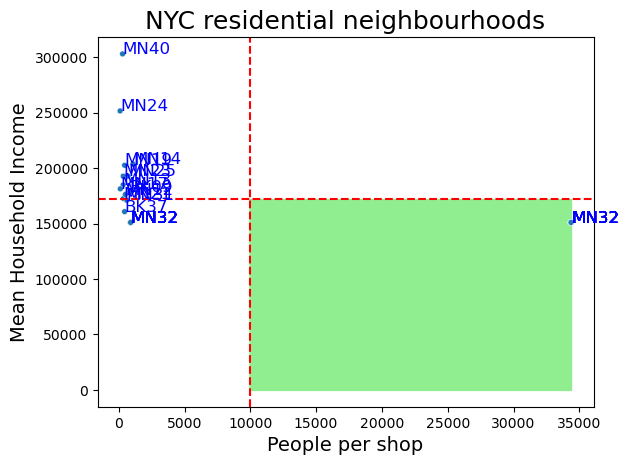

In [130]:
# visualisation
def scatter_text(x, y, text_column, data, title, xlabel, ylabel):
    # Create the scatter plot
    p1 = sns.scatterplot(x=x, y=y, data=data, size=8, legend=False)
    # Add text besides each point

    
    texts = [p1.text(data[x][line], data[y][line], 
             data[text_column][line], horizontalalignment='left', 
             size='large', color='blue') for line in range(0,data.shape[0])]
    # Set title and axis labels
    plt.title(title, size=18)
    plt.xlabel(xlabel, size=14)
    plt.ylabel(ylabel, size=14)
    return p1
    
# Add horizontal and vertical lines to mark the median values
avg_people_per_market = nyc_label_0['People_Per_Shop'].mean()
max_people_per_market = nyc_label_0['People_Per_Shop'].max()
avg_income = nyc_label_0['Mean_Household_Income'].mean()

plt.axhline(y=avg_income, color='r', linestyle='--')
plt.axvline(x=avg_people_per_market, color='r', linestyle='--')

# Highlight the optimal quadrant
plt.fill_between(x=np.arange(avg_people_per_market, max_people_per_market), y1=0, y2=avg_income, color='lightgreen')

# Draw and label the neighbourhood points
scatter_text('People_Per_Shop', 'Mean_Household_Income', 'GeoID',
             data = nyc_label_0, 
             title = 'NYC residential neighbourhoods', 
             xlabel = 'People per shop',
             ylabel = 'Mean Household Income')

In [133]:
nyc_label_0_filterd = nyc_label_0[(nyc_label_0['Mean_Household_Income'] < avg_income) & (nyc_label_0['People_Per_Shop'] > avg_people_per_market)]

In [134]:
nyc_label_0_filterd.loc[nyc_label_0_filterd.People_Per_Shop.idxmax()]

index                           105
Pop_Total_25_44               34367
Pop_Pct_25_44              0.422833
Pop_Pct_Hisp_Latin         0.103386
Pop_Pct_Non_Hisp_Latin     0.896614
Pop_Pct_Employ             0.718739
Pop_Pct_Earn_75_99         0.117675
Mean_Household_Income      150969.0
Pop_Pct_Healthy            0.949504
Pop_Pct_With_Car            0.27061
House_Median               729638.0
Rent_Median                  2088.0
Pop_Pct_with_Family        0.384561
Pop_Pct_With_Degree        0.789317
Shop_Count                        1
People_Per_Shop             34367.0
GeoID                          MN32
label                             1
GeogName                  Yorkville
Borough                   Manhattan
Name: 13, dtype: object

In [76]:
nyc_label_0_filterd.sort_values('People_Per_Shop')

,index,Pop_Total_25_44,Pop_Pct_25_44,Pop_Pct_Hisp_Latin,Pop_Pct_Non_Hisp_Latin,Pop_Pct_Employ,Pop_Pct_Earn_75_99,Mean_Household_Income,Pop_Pct_Healthy,Pop_Pct_With_Car,House_Median,Rent_Median,Pop_Pct_with_Family,Pop_Pct_With_Degree,shop_count,GeoID,label,GeogName,Borough,People_Per_Shop
1,100,14871,0.253802,0.070486,0.929514,0.612262,0.099536,302939.0,0.979035,0.352811,2000000.0,2251.0,0.514452,0.844983,51,MN40,2,Upper East Side-Carnegie Hill,Manhattan,291
